In [1]:

device = 'cuda:2'

In [2]:
import fairseq

cp_path = './xlsr2_300m.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model = model.to(device)

In [3]:
model.eval()

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True

In [4]:
# Load audio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torchaudio
import librosa.display

def load_audio(path):
    audio, sample_rate = torchaudio.load(path)
    return audio, sample_rate

audio, sample_rate = load_audio('./common_voice_en_1164.wav')
audio = audio.to(device)

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
result = model(audio)

In [ ]:
result

{'x': tensor([[[ 8.3648,  8.3167,  8.3030,  ...,  3.1697,  5.6738,  3.8660]],
 
         [[ 0.6783, -1.0600, -1.1960,  ..., -0.6905, -0.3537, -1.9690]],
 
         [[-1.0857, -0.3033, -0.3055,  ...,  3.6718,  2.9303, -0.2055]],
 
         ...,
 
         [[-1.0979, -1.4805, -1.1521,  ..., -1.9941,  2.9714,  0.7419]],
 
         [[-1.4422,  3.1892, -1.1521,  ..., -1.8441,  0.5753, -0.2055]],
 
         [[-1.4351, -1.3588, -1.2608,  ...,  1.3034, -2.6668,  1.4338]]],
        device='cuda:2', grad_fn=<CopySlices>),
 'padding_mask': None,
 'features_pen': tensor(0.0108, device='cuda:2', grad_fn=<MeanBackward0>),
 'prob_perplexity': tensor(37.6999, device='cuda:2', grad_fn=<SumBackward0>),
 'code_perplexity': tensor(37.0842, device='cuda:2'),
 'num_vars': 640,
 'temp': 0.1}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def target_category_loss(x, category_index, nb_classes):
    return torch.mul(x, F.one_hot(category_index, nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (torch.sqrt(torch.mean(torch.square(x))) + 1e-5)

def resize_1d(array, shape):
    res = np.zeros(shape)
    if array.shape[0] >= shape:
        ratio = array.shape[0]/shape
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) != shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]
        array = array[::-1]
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) != shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]/(2*ratio)
        array = array[::-1]
    else:
        ratio = shape/array.shape[0]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left += 1
                right += 1
            if right > array.shape[0]-1:
                res[i] += array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]
        array = array[::-1]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left += 1
                right += 1
            if right > array.shape[0]-1:
                res[i] += array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]/2
        array = array[::-1]
    return res

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = []
        self.activations = []

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def save_gradient(self, module, grad_input, grad_output):

        self.gradients = [grad_output[0]] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)


class BaseCAM:
    def __init__(self, model, target_layer, device=None):
        self.model = model.eval()
        self.target_layer = target_layer
        self.device = device
        if self.device is not None:
            self.model = model.to(device)

        self.activations_and_grads = ActivationsAndGradients(self.model, target_layer)

    def forward(self, input_img):
        return self.model(input_img)

    def get_cam_weights(self, input_tensor, target_category, activations, grads):
        raise Exception("Not Implemented")

    def get_loss(self, output, target_category):
        return output[target_category]

    def __call__(self, input_tensor, target_category=None):
        if self.device is not None:
            input_tensor = input_tensor.to(self.device)

        output = self.activations_and_grads(input_tensor)

        if target_category is None:
            output = output.squeeze()
            target_category = np.argmax(output.cpu().data.numpy())

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0, :]
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(input_tensor, target_category, activations, grads)

        cam = np.sum(activations * weights[:, None], axis=0)

        cam = np.interp(np.linspace(0, cam.shape[0], input_tensor.shape[-1]), np.linspace(0, cam.shape[0], cam.shape[0]), cam)

        heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

        return heatmap

class GradCAMWav2Vec(BaseCAM):
    def __init__(self, model, target_layer, device=None):
        super(GradCAMWav2Vec, self).__init__(model, target_layer, device)

    def forward(self, input_img):
        return self.model(input_img)['x']

    def get_cam_weights(self, input_tensor,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads ** 2
        grads_power_3 = grads_power_2 * grads
        sum_activations = np.sum(activations, axis=1)
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 + sum_activations[:, None] * grads_power_3 + eps)
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=1)
        return weights

    def get_loss(self, output, target_category=None):
        # Here, you could either take a specific embedding or average them all.
        # This is a naive implementation and might need adjustments based on your specific needs.
        return output[0, 0, target_category] if target_category is not None else output.mean()
    
    def __call__(self, input_tensor, target_category=None):
        if self.device is not None:
            input_tensor = input_tensor.to(self.device)

        output = self.activations_and_grads(input_tensor)['x']

        # Assuming target_category is given as an integer index or is None
        if target_category is None:
            output_mean = output.mean(dim=1).squeeze()  # Take the mean across channels
            target_category = torch.argmax(output_mean).item()

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0, :]
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(input_tensor, target_category, activations, grads)

        cam = np.sum(activations * weights[:, None], axis=0)

        cam = np.maximum(cam, 0)

        cam = np.interp(np.linspace(0, cam.shape[0], input_tensor.shape[-1]), np.linspace(0, cam.shape[0], cam.shape[0]), cam)

        heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

        return heatmap
    
  

In [ ]:

target_layer = model.feature_extractor.conv_layers[6][0]
heatmap = GradCAMWav2Vec(model, target_layer, device)(audio)


In [ ]:
heatmap.shape

(334704,)

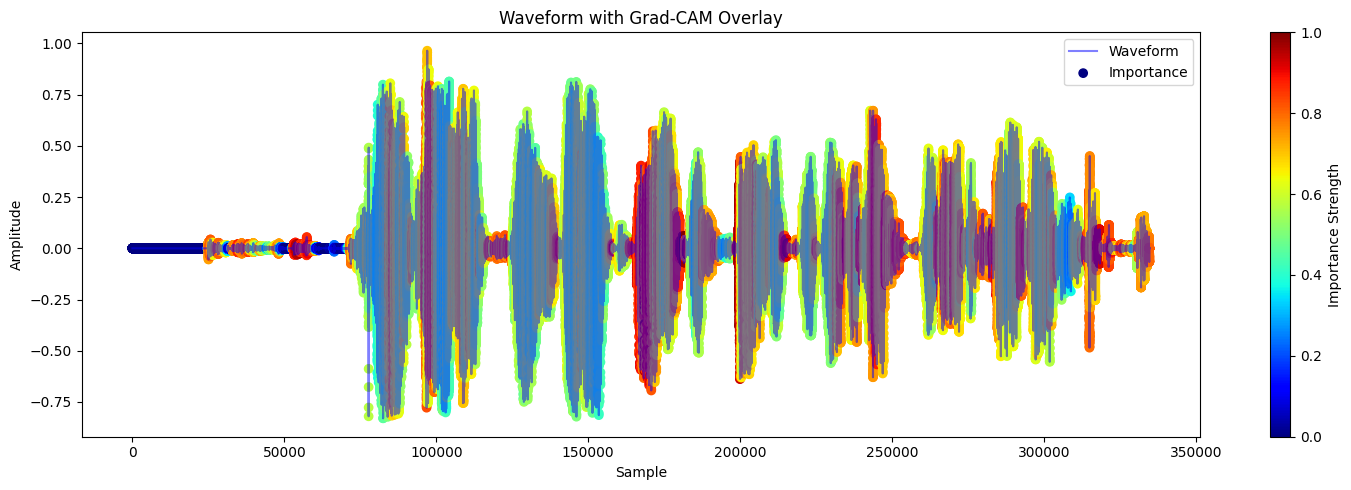

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize_heatmap_and_waveform(heatmap, waveform, start_idx=0):
    # Assuming waveform is a PyTorch tensor; convert it to numpy array
    waveform = waveform.squeeze().cpu().numpy()
    
    # Check if the lengths are different; if so, interpolate heatmap

    # upsample_heatmap = np.interp(np.linspace(0, len(waveform), len(waveform)),
    #                         np.linspace(0, len(heatmap), len(heatmap)),
    #                         heatmap)
    
    plt.figure(figsize=(15, 5))
    x_values = np.arange(start_idx, start_idx + len(waveform))
    plt.plot(x_values, waveform, label='Waveform', color='blue', alpha=0.5)
    plt.scatter(x_values, waveform, c=heatmap, cmap=cm.jet, label='Importance')
    plt.title('Waveform with Grad-CAM Overlay')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    cbar = plt.colorbar()
    cbar.set_label('Importance Strength')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming heatmap and waveform variables are already defined and ready
# If transform(waveform.to(device)) results in a transformed waveform, 
# assign its result to a variable before passing it to the visualization function.

visualize_heatmap_and_waveform(heatmap, audio)


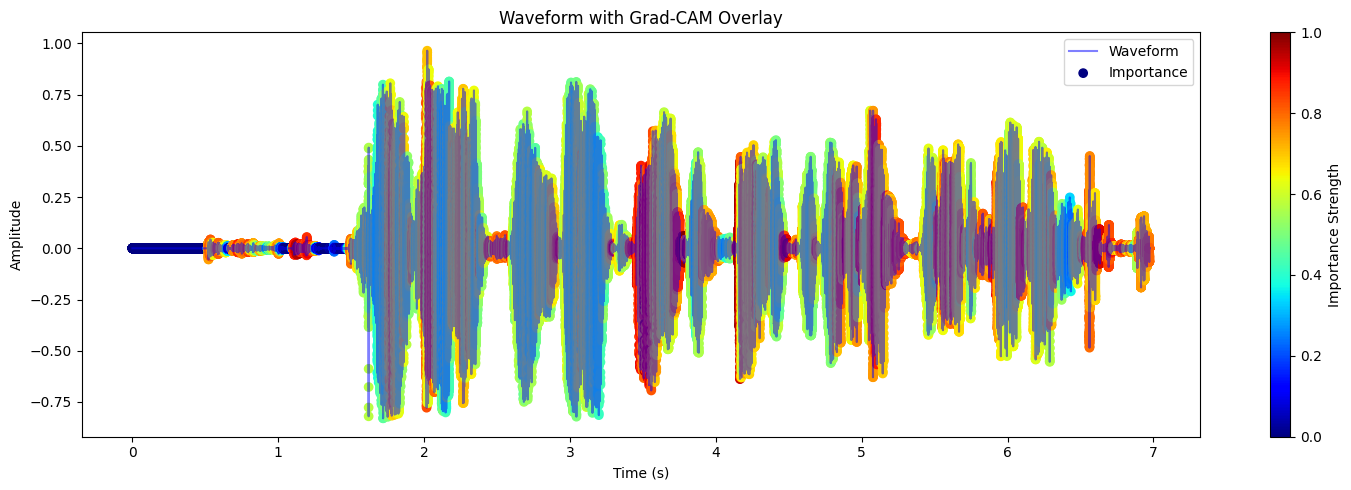

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def visualize_heatmap_and_waveform(heatmap, waveform, sample_rate, start_time=0, end_time=None):
    # Assuming waveform is a PyTorch tensor; convert it to a numpy array
    waveform = waveform.squeeze().cpu().numpy()
    
    # Calculate the time array in seconds based on the sample rate
    time_in_seconds = np.arange(0, len(waveform)) / sample_rate


    if end_time is not None:
        start_idx = int(start_time * sample_rate)
        end_idx = int(end_time * sample_rate)
        time_in_seconds = time_in_seconds[start_idx:end_idx]
        waveform = waveform[start_idx:end_idx]
        heatmap = heatmap[start_idx:end_idx]

    plt.figure(figsize=(15, 5))
    
    plt.plot(time_in_seconds, waveform, label='Waveform', color='blue', alpha=0.5)
    plt.scatter(time_in_seconds, waveform, c=heatmap, cmap=cm.jet, label='Importance')

    plt.title('Waveform with Grad-CAM Overlay')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    cbar = plt.colorbar()
    cbar.set_label('Importance Strength')
    plt.legend()
    plt.tight_layout()
    plt.show()
# Assuming heatmap and waveform variables are already defined and ready
# If transform(waveform.to(device)) results in a transformed waveform, 
# assign its result to a variable before passing it to the visualization function.

visualize_heatmap_and_waveform(heatmap, audio, sample_rate, start_time=0)

In [ ]:
audio[0][150000:200000]

tensor([0.2529, 0.2646, 0.2786,  ..., 0.2143, 0.2168, 0.2160], device='cuda:2')

In [ ]:

visualize_heatmap_and_waveform(heatmap, audio[0][150000:195000], start_idx=150000)

TypeError: visualize_heatmap_and_waveform() got an unexpected keyword argument 'start_idx'

In [ ]:
import torchaudio

# Load the audio file
file_path = "./common_voice_en_1164.wav"  # Replace with your audio file path
waveform, sample_rate = torchaudio.load(file_path)

# Get the sampling rate
print(f"Sampling Rate: {sample_rate} Hz")

In [ ]:
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
import torchaudio.transforms as T

def linear_n_play(audio_path):
    # Load the audio with torchaudio
    audio, sample_rate = torchaudio.load(audio_path, num_frames=None, normalize=True)

    # Desired number of time bins (X) and frequency bins (Y)
    X = 128
    Y = audio.shape[0] // X

    # Compute the mel spectrogram
    # Calculate n_fft
    n_fft = signal_length - (X - 1) * hop_length

    # Create the spectrogram with the calculated parameters
    transform = T.MelSpectrogram(sample_rate=sample_rate,n_fft=n_fft, hop_length=hop_length, n_mels=Y)

    mel_spectrogram = transform(audio)

    print(mel_spectrogram.shape)

    # Convert the mel spectrogram to decibels
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

    # Create a time array
    time = torch.arange(0, audio.shape[1]) / sample_rate

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram_db[0].numpy(), cmap='viridis', origin='lower', aspect='auto', interpolation='none', extent=[0, time[-1], 0, sample_rate/2])
    plt.title('Linear-frequency power spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    # Play the audio
    display(Audio(audio[0].numpy(), rate=sample_rate))


In [ ]:
linear_n_play('./common_voice_en_1164.wav')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
from scipy import interpolate

def spectrogram_like_representation(waveform, sample_rate, grad_cam_heatmap):
        # Create the mel spectrogram using torchaudio
    mel_spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)
    
    # Convert to decibels
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    
    # Ensure that grad_cam_heatmap has the same length as the number of mel bands
    grad_cam_heatmap = grad_cam_heatmap[:len(mel_spectrogram_db[0])]
    
    # Upsample the heatmap to match the spectrogram dimensions
    x = np.arange(len(grad_cam_heatmap))
    y = np.arange(len(mel_spectrogram_db[0]))
    f = interpolate.interp2d(x, y, grad_cam_heatmap)
    upsampled_heatmap = f(np.arange(len(grad_cam_heatmap)), np.arange(len(mel_spectrogram_db[0])))
    
    # Display the mel spectrogram with the overlaid heatmap
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram_db[0].numpy(), cmap='viridis', origin='lower', aspect='auto', interpolation='none')
    plt.imshow(upsampled_heatmap, alpha=0.5, cmap='viridis', origin='lower', aspect='auto', interpolation='none')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency Bands")
    plt.title("Mel Spectrogram with Heatmap")
    plt.show()



In [ ]:
spectrogram_like_representation(audio.cpu(), sample_rate, heatmap)

NameError: name 'spectrogram_like_representation' is not defined

In [ ]:
device = 'cuda:3'

In [ ]:
from Simplified_CM_solution import Model

model = Model({}, device)

In [ ]:
audio

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0002, -0.0002, -0.0002]],
       device='cuda:2')

In [ ]:
result = model(audio.to(device))
result

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cpu! (when checking argument for argument mat2 in method wrapper_mm)